# 02. Neural Network classificaition with PyTorch

Classificaiont is a problem of predicting whether something is one thing or another

## 1. Make classification data and get it ready

In [1]:
import sklearn
from sklearn.datasets import make_circles

In [2]:
n_samples = 1000

X, y = make_circles(n_samples, noise=0.03, random_state=42)

len(X), len(y), X[:5], y[:5]

(1000,
 1000,
 array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0], dtype=int64))

In [3]:
import pandas as pd
circles = pd.DataFrame({
    "X1": X[:,0],
    "X2": X[:,1],
    "label": y
})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


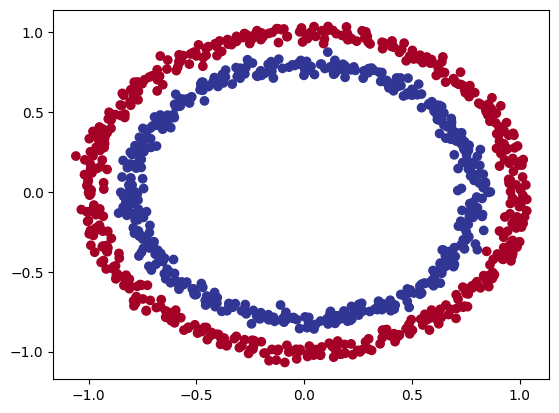

In [4]:
import matplotlib.pyplot as plt

plt.scatter(x=X[:,0], y=X[:,1], c=y, cmap=plt.cm.RdYlBu)

### 1.1 Check input and output shapess

In [5]:
X.shape, y.shape

((1000, 2), (1000,))

In [6]:
X_sample = X[0]
y_sample = y[0]

X_sample, y_sample, X_sample.shape, y_sample.shape

(array([0.75424625, 0.23148074]), 1, (2,), ())

### 1.2 Turn data into tensors and create train and test splits

In [7]:
import torch
torch.__version__

'2.3.0+cpu'

In [8]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    test_size=0.2,
    random_state=42
)

len(X_train), len(X_test)

(800, 200)

## 2. Building a model

In [10]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"

In [34]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()

        # takes 2 features and out scaless to 5. More hidden features, more chances to learn patterns
        self.layer_1 = nn.Linear(
            in_features=2, 
            out_features=128
        )
        self.layer_2 = nn.ReLU()
        # takes in 5 features from previous layer and outputs a single feature same as y
        self.layer_3 = nn.Linear(
            in_features=128, 
            out_features=1
        )

    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x))) # x -> layer_1 -> layer_2

model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=128, bias=True)
  (layer_2): ReLU()
  (layer_3): Linear(in_features=128, out_features=1, bias=True)
)

In [12]:
# model_0 = nn.Sequential(
#     nn.Linear(
#         in_features=2, 
#         out_features=5
#     ),
#     nn.Linear(
#         in_features=5, 
#         out_features=1
#     ),    
# )

# model_0

In [31]:
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188]])),
             ('layer_1.bias',
              tensor([0.6146, 0.1323, 0.5224, 0.0958, 0.3410])),
             ('layer_3.weight',
              tensor([[-0.0631,  0.3448,  0.0661, -0.2088,  0.1140]])),
             ('layer_3.bias', tensor([-0.2060]))])

In [14]:
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
len(untrained_preds), untrained_preds.shape, len(X_test), X_test.shape, untrained_preds[:10], y_test[:10]

(200,
 torch.Size([200, 1]),
 200,
 torch.Size([200, 2]),
 tensor([[-0.1373],
         [-0.0603],
         [-0.0257],
         [-0.1702],
         [ 0.4717],
         [ 0.5149],
         [ 0.3374],
         [ 0.4733],
         [-0.0468],
         [-0.0496]]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

### 2.1 Setup loss function and optimiser

In [15]:
loss_fn = nn.BCEWithLogitsLoss()
optimiser = torch.optim.SGD(
    params=model_0.parameters(),
    lr=0.1
)

In [16]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true,y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

## Train Model

In [17]:
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.1373],
        [-0.0603],
        [-0.0257],
        [-0.1702],
        [ 0.4717]])

In [18]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4657],
        [0.4849],
        [0.4936],
        [0.4576],
        [0.6158]])

In [19]:
y_preds = torch.round(y_pred_probs)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

torch.eq(y_preds.squeeze(), y_pred_labels.squeeze())

tensor([True, True, True, True, True])

In [20]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

### 3.2 Building a traiing and test loop

In [35]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_0.train()

    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(
        y_logits,
        y_train
    )
    acc = accuracy_fn(
        y_true=y_train, 
        y_pred=y_pred
    )
    
    optimiser.zero_grad()

    loss.backward()

    optimiser.step()


    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(
            test_logits,
            y_test
        )

    test_acc = accuracy_fn(
        y_true=y_test,
        y_pred=test_pred
    )

    if epoch % 10 == 0:
        print(epoch, loss, acc, test_loss, test_acc)
        

0 tensor(0.6964, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) 49.5 tensor(0.6981) 49.0
10 tensor(0.6964, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) 49.5 tensor(0.6981) 49.0
20 tensor(0.6964, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) 49.5 tensor(0.6981) 49.0
30 tensor(0.6964, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) 49.5 tensor(0.6981) 49.0
40 tensor(0.6964, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) 49.5 tensor(0.6981) 49.0
50 tensor(0.6964, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) 49.5 tensor(0.6981) 49.0
60 tensor(0.6964, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) 49.5 tensor(0.6981) 49.0
70 tensor(0.6964, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) 49.5 tensor(0.6981) 49.0
80 tensor(0.6964, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) 49.5 tensor(0.6981) 49.0
90 tensor(0.6964, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) 49.5 tensor(0.6981) 49.0


## 4. Make predictions and evaluate model

model doesnt seem to be learning anything.

In [22]:
import requests
from pathlib import Path

if not Path("helper_functions.py").is_file():
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

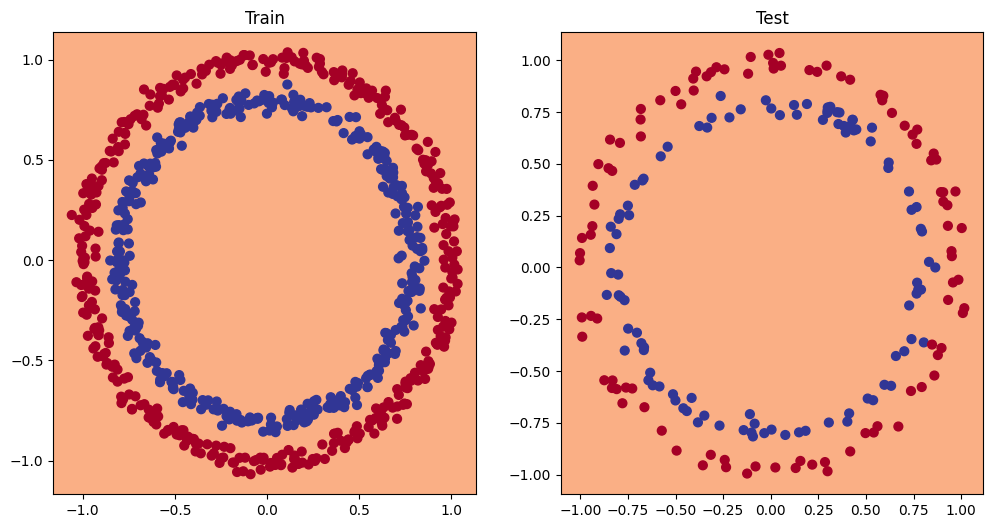

In [33]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model

* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units - go from 5 hidden units to 10
* Fit for longer
* Changing activation functions (sigmoid)
* Change learning rate
* Change loss function

In [71]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_1 = nn.Linear(
            in_features=2, 
            out_features=128
        )
        self.layer_2 = nn.Linear(
            in_features=128, 
            out_features=128
        )
        self.layer_3 = nn.Linear(
            in_features=128, 
            out_features=1
        )
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

0 tensor(0.6936, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) 50.0 tensor(0.6943) 50.0
100 tensor(0.6688, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) 79.375 tensor(0.6740) 79.0
200 tensor(0.6148, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) 97.125 tensor(0.6287) 91.5
300 tensor(0.4820, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) 99.0 tensor(0.5138) 98.0
400 tensor(0.2820, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) 99.625 tensor(0.3290) 99.0
500 tensor(0.1524, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) 99.875 tensor(0.1967) 100.0
600 tensor(0.0850, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) 100.0 tensor(0.1212) 100.0
700 tensor(0.0547, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) 100.0 tensor(0.0846) 100.0
800 tensor(0.0388, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) 100.0 tensor(0.0644) 100.0
900 tensor(0.0295, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) 100.0 tensor(0.0520) 100.0


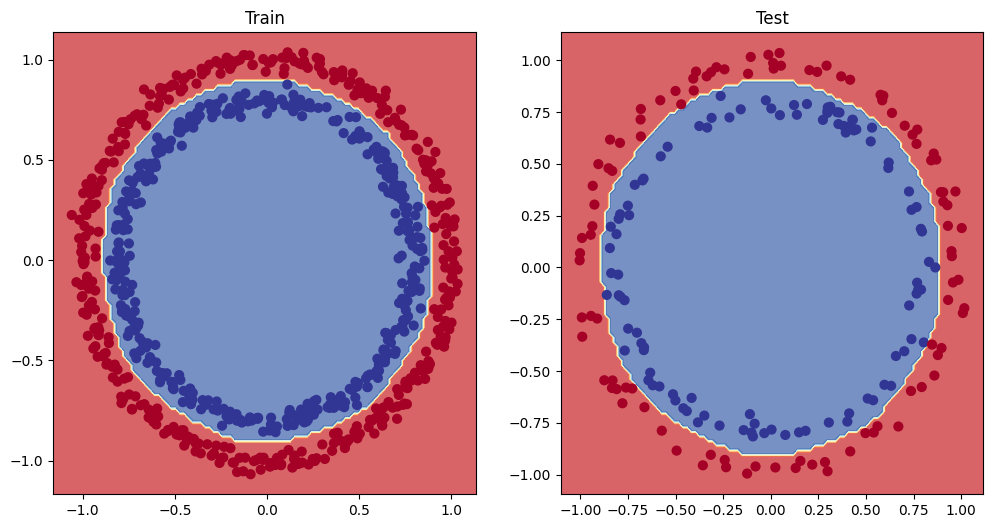

In [72]:
loss_fn = nn.BCEWithLogitsLoss()
optimiser = torch.optim.SGD(
    params=model_1.parameters(),
    lr=0.1
)

torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_1.train()

    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(
        y_logits,
        y_train
    )
    acc = accuracy_fn(
        y_true=y_train, 
        y_pred=y_pred
    )
    
    optimiser.zero_grad()

    loss.backward()

    optimiser.step()


    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(
            test_logits,
            y_test
        )

    test_acc = accuracy_fn(
        y_true=y_test,
        y_pred=test_pred
    )

    if epoch % 100 == 0:
        print(epoch, loss, acc, test_loss, test_acc)


plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

In [68]:
model_1.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_1(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))